# Greenland's ice sheet remote sensing datasets - Exploration

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

from netCDF4 import Dataset
import xarray as xr
import rioxarray
import rasterio

## microwave-rs

### Load data

In [9]:
microwave_path = r"..\Data\microwave-rs\CumJour-North-ssmi-1979-2022-H19.nc"

In [69]:
data_mw = xr.open_dataset(microwave_path)

# dimensions(sizes): y(109), x(60), time(15663), nv(4)
# variables(dimensions): 
# float32 lat(y, x), 
# float32 lon(y, x), 
# int64 time(time), 
# float32 bounds_lat(y, x, nv), 
# float32 bounds_lon(y, x, nv), 
# float64 x(x), 
# float64 y(y), 
# int64 spatial_ref(), 
# int8 melt(time, y, x)

DIMENSIONS:
- x and y - projected (cartesian) coordinate system
- time - number of days
- nv - 4 corners of pixel

In [70]:
print(data_mw.dims)
print(data_mw.attrs)
print(data_mw.coords)

Frozen({'y': 109, 'x': 60, 'time': 15663, 'nv': 4})
{}
Coordinates:
  * time     (time) datetime64[ns] 1979-11-01 1979-11-02 ... 2022-10-30
  * x        (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 7.75e+05 8e+05 8.25e+05
  * y        (y) float64 -6.25e+05 -6.5e+05 -6.75e+05 ... -3.3e+06 -3.325e+06


In [21]:
#for var in data_mw.variables.values():
#    print(var)

In [71]:
data_mw

<xarray.Dataset>
Dimensions:      (y: 109, x: 60, time: 15663, nv: 4)
Coordinates:
  * time         (time) datetime64[ns] 1979-11-01 1979-11-02 ... 2022-10-30
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
Dimensions without coordinates: nv
Data variables:
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
    bounds_lat   (y, x, nv) float32 ...
    bounds_lon   (y, x, nv) float32 ...
    spatial_ref  int64 ...
    melt         (time, y, x) float32 ...

Filter for June/July 2019 to have a smaller project base

In [72]:
# storing full latitude and longitude values for visualization
lat = data_mw.variables['lat'][:]
lon = data_mw.variables['lon'][:]

bottom_filter = np.datetime64('2019-06-01')
top_filter = np.datetime64('2019-07-31')
data_mw = data_mw.where((bottom_filter <= data_mw["time"]) & (data_mw["time"] <= top_filter), drop=True)
data_mw

<xarray.Dataset>
Dimensions:      (y: 109, x: 60, time: 61, nv: 4)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01 2019-06-02 ... 2019-07-31
  * x            (x) float64 -6.5e+05 -6.25e+05 -6e+05 ... 8e+05 8.25e+05
  * y            (y) float64 -6.25e+05 -6.5e+05 ... -3.3e+06 -3.325e+06
Dimensions without coordinates: nv
Data variables:
    lat          (y, x, time) float32 81.69 81.69 81.69 ... 58.99 58.99 58.99
    lon          (y, x, time) float32 -90.0 -90.0 -90.0 ... -30.91 -30.91 -30.91
    bounds_lat   (y, x, nv, time) float32 81.69 81.69 81.69 ... 58.91 58.91
    bounds_lon   (y, x, nv, time) float32 -91.12 -91.12 -91.12 ... -31.17 -31.17
    spatial_ref  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    melt         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

In [75]:
data_mw.to_dataframe()

lat        lon  bounds_lat  \
y          x         time       nv                                     
-625000.0  -650000.0 2019-06-01 0   81.691437 -90.000000   81.689842   
                                1   81.691437 -90.000000   81.853821   
                                2   81.691437 -90.000000   81.689842   
                                3   81.691437 -90.000000   81.529091   
                     2019-06-02 0   81.691437 -90.000000   81.689842   
...                                       ...        ...         ...   
-3325000.0  825000.0 2019-07-30 3   58.985001 -30.913275   58.906670   
                     2019-07-31 0   58.985001 -30.913275   59.115292   
                                1   58.985001 -30.913275   59.062782   
                                2   58.985001 -30.913275   58.854580   
                                3   58.985001 -30.913275   58.906670   

                                    bounds_lon  spatial_ref  melt  
y          x         time       nv                                 
-625000.0  -650000.0 2019-06-01 0   -91.123306          0.0   0.0  
                                1   -90.000000          0.0   0.0  
                                2   -88.876694          0.0   0.0  
                                3   -90.000000          0.0   0.0  
                     2019-06-02 0   -91.123306          0.0   0.0  
...                                        ...          ...   ...  
-3325000.0  825000.0 2019-07-30 3   -31.165148          0.0   NaN  
                     2019-07-31 0   -31.065165          0.0   NaN  
                                1   -30.660072          0.0   NaN  
                                2   -30.762720          0.0   NaN  
                                3   -31.165148          0.0   NaN  

[1595760 rows x 6 columns]

In [67]:
data_mw.spatial_ref.crs_wkt

'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]'

### Variables

In [30]:
lats_nc = data_mw.variables['lat'][:]
lons_nc = data_mw.variables['lon'][:]
melt_nc = data_mw.variables['melt'][:]
time_nc = data_mw.variables['time'][:]
bounds_lat_nc = data_mw.variables['bounds_lat'][:]
bounds_lon_nc = data_mw.variables['bounds_lon'][:]
xx_nc = data_mw.variables['x'][:]
yy_nc = data_mw.variables['y'][:]
spatial_ref_nc = data_mw.variables['spatial_ref'][:]

### Plot

In [37]:
#fig, axs = plt.subplots(figsize=(5, 5),  nrows=2, ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True) #
#pcm=axs[0].pcolormesh(bounds_lat, bounds_lat, np.ma.getdata(melt[1]),cmap='viridis')
#pcm=axs[0].pcolormesh(lons, lats, np.ma.getdata(melt[1]), cmap='Greys') # 'viridis'
#cbar=fig.colorbar(pcm,cax=axs[1], extend='both', orientation='horizontal')
#cbar.set_label('PM 2.5 [$\mu$g m$^{-3}]$')

C:\Users\ninaz\AppData\Local\Temp\ipykernel_19168\2184731550.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(figsize=(3, 3),  nrows=2, ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True) #


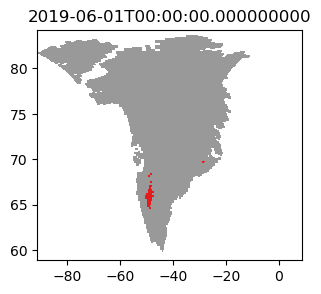

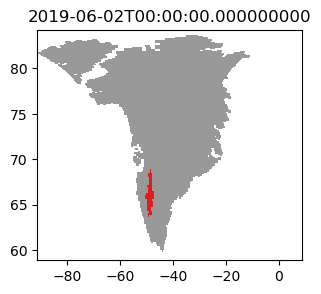

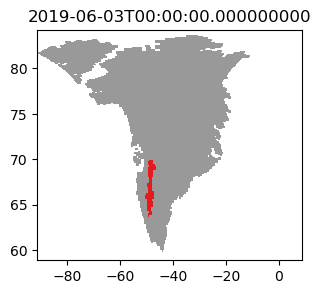

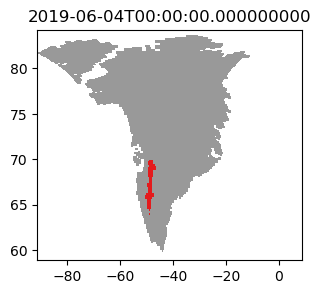

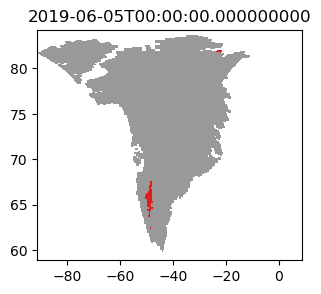

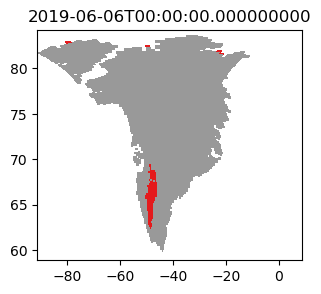

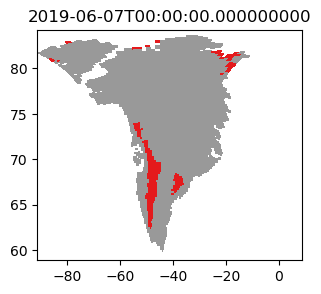

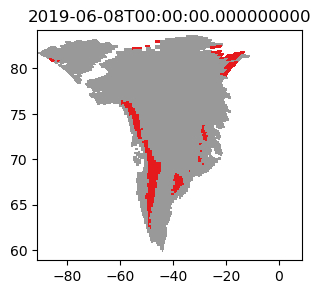

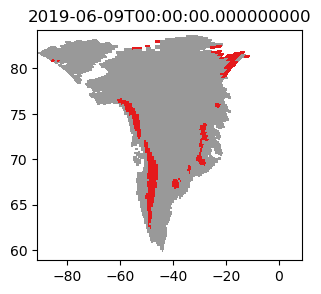

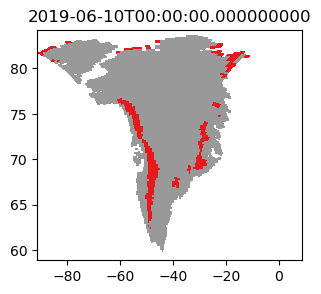

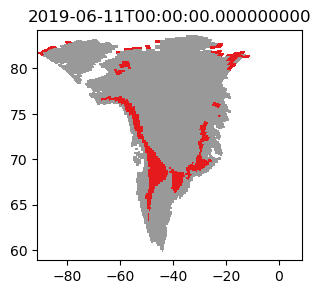

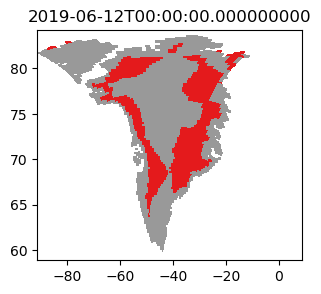

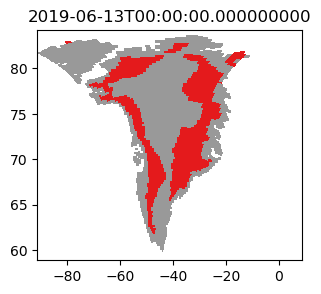

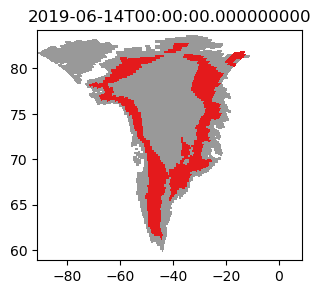

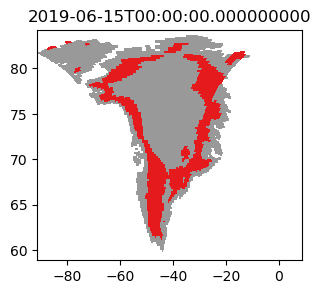

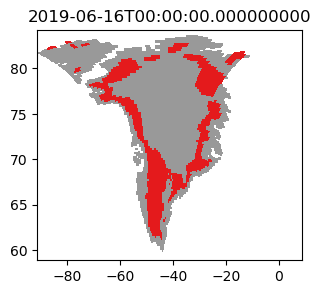

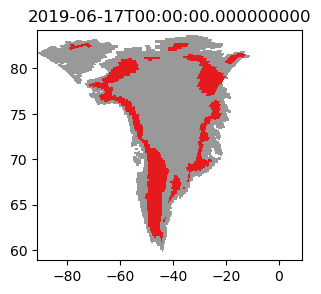

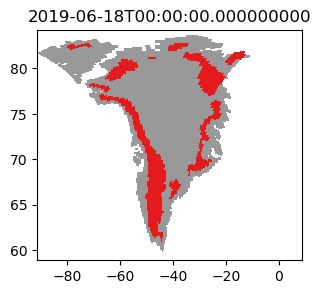

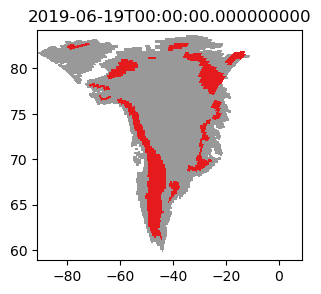

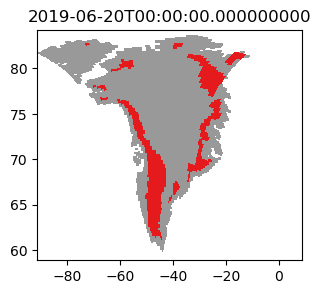

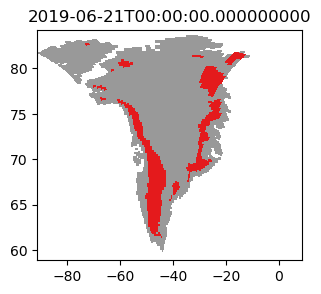

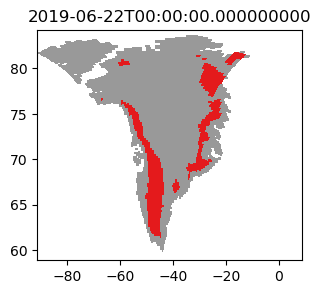

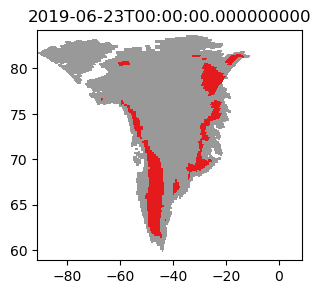

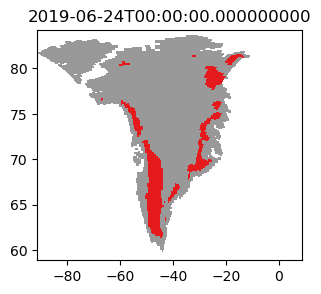

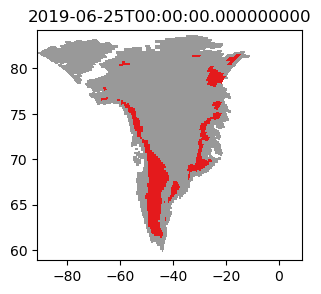

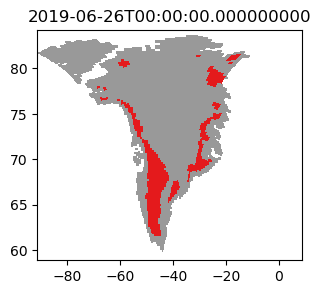

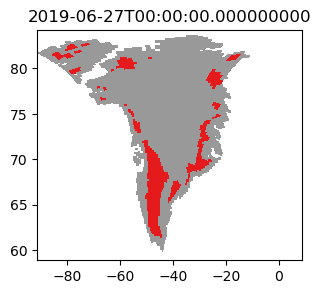

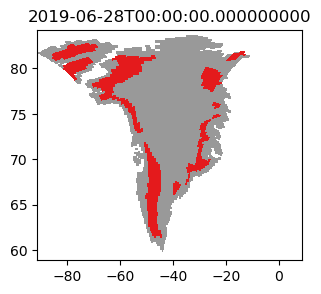

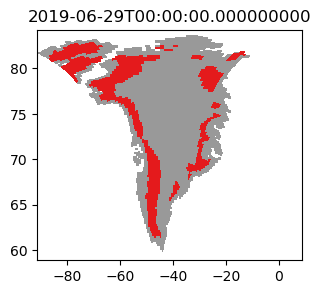

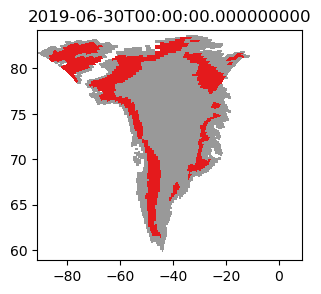

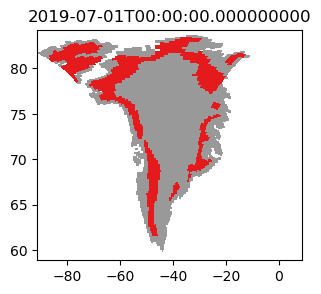

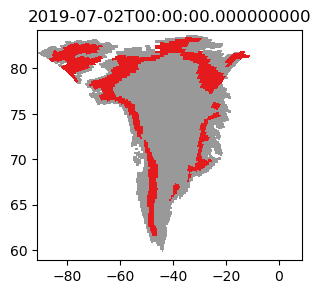

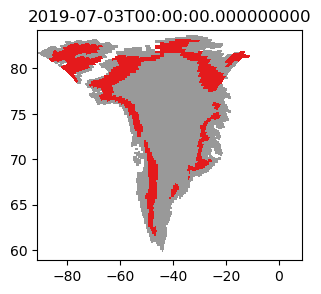

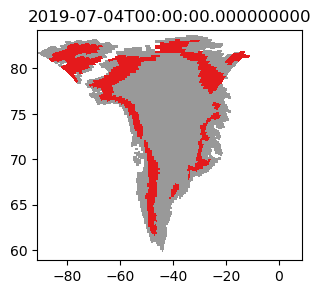

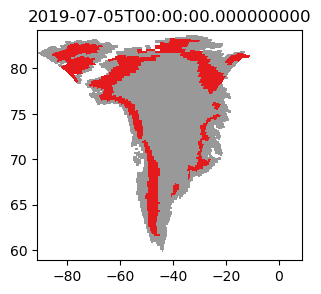

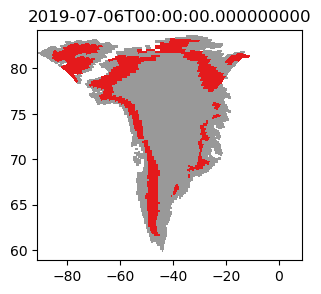

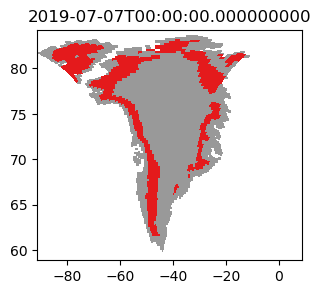

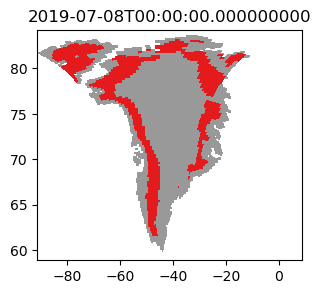

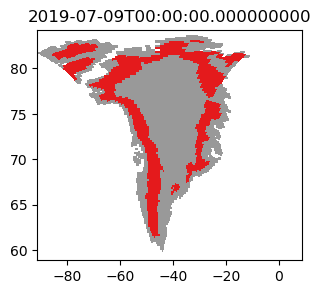

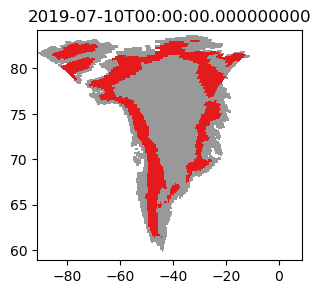

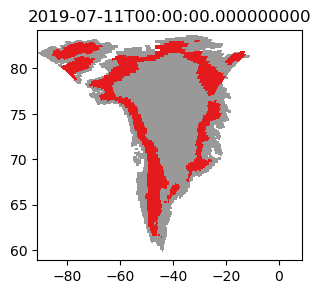

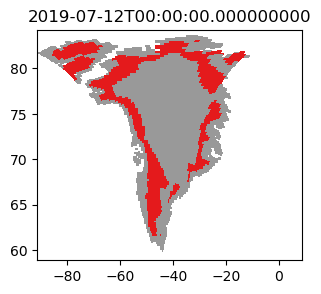

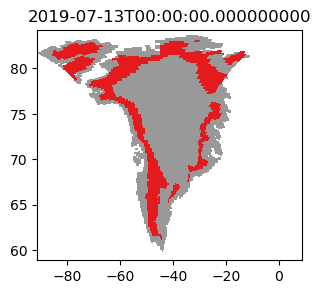

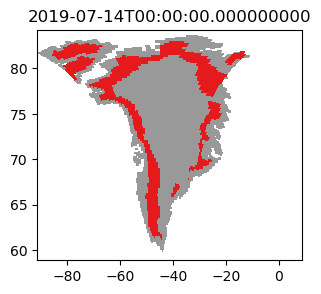

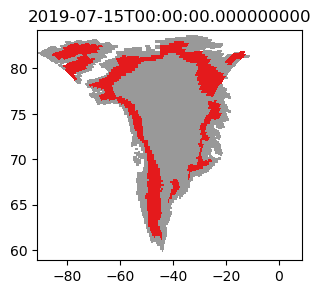

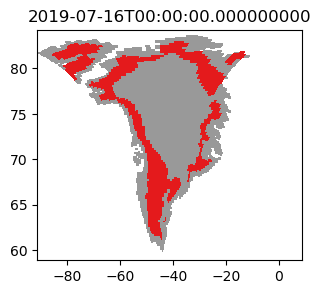

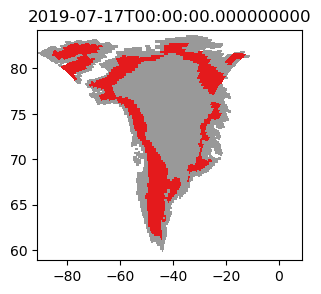

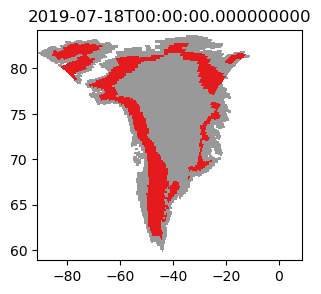

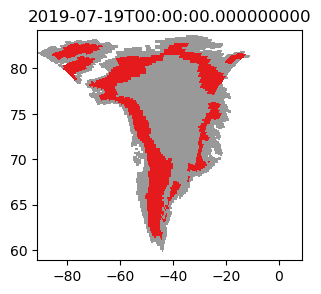

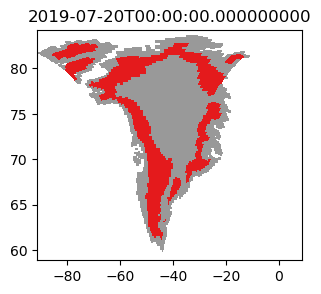

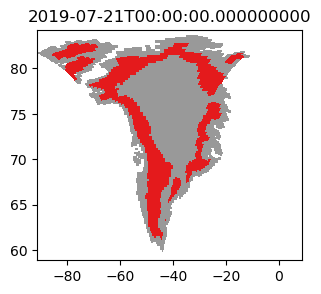

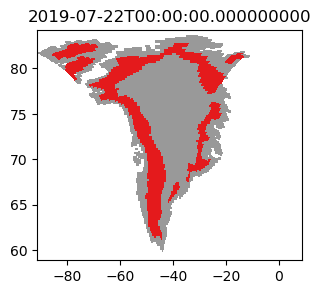

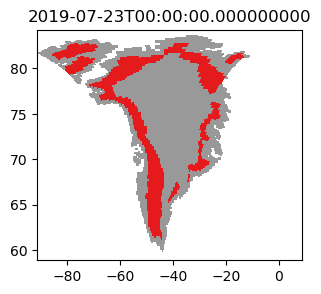

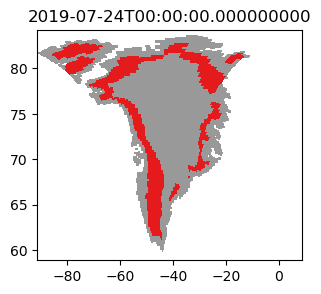

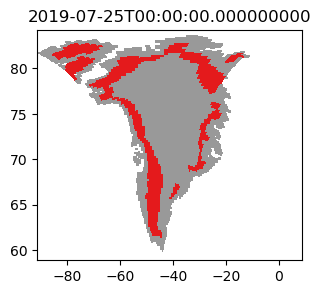

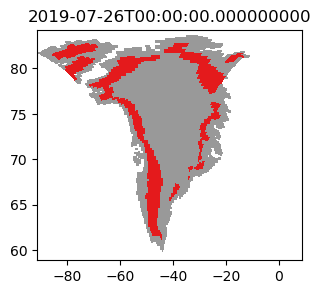

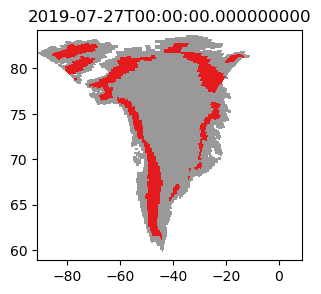

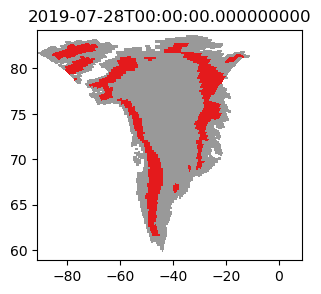

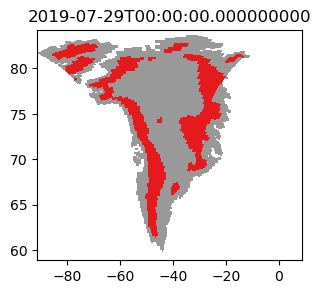

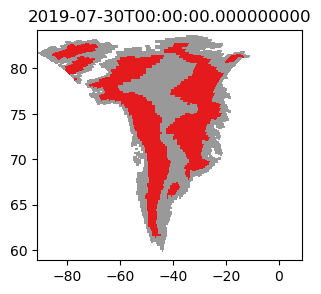

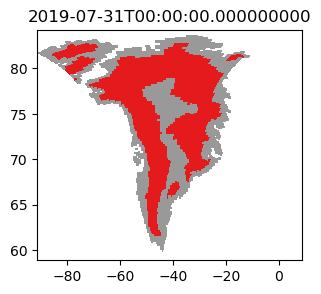

In [39]:
for i in range(len(melt_nc)):
    fig, axs = plt.subplots(figsize=(3, 3),  nrows=2, ncols=1,gridspec_kw={'height_ratios': [20,1.5]},constrained_layout=True) #
    plot = axs[0].pcolormesh(lon, lat, np.ma.getdata(melt_nc[i]), cmap='Set1_r') # 'viridis'
    axs[0].set_title(time_nc.values[i])
    cbar=fig.colorbar(plot, cax=axs[1], extend='both', orientation='horizontal')
    cbar.remove()

## optical data

#### load data

In [41]:
optical_path ='../Data/optical-rs/2019-06-08_grain_diameter.tif'

In [42]:
im = Image.open(optical_path) # # im.show()
 #xarr ay loaddataset #...toDataframe9)

In [ ]:
with rasterio.open(optical_path) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        #print(geom)

In [63]:
# metadata
#img = Image.open(optical_path)
#meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}

#meta_dict

In [76]:
data_opt = rioxarray.open_rasterio(optical_path)
data_opt 

<xarray.DataArray (band: 1, y: 2687, x: 1487)>
[3995569 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -6.365e+05 -6.355e+05 ... 8.485e+05 8.495e+05
  * y            (y) float64 -6.625e+05 -6.635e+05 ... -3.348e+06 -3.348e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

In [77]:
with rasterio.open(optical_path) as dataset_opt:
    print(dataset_opt.crs)

EPSG:3413


In [78]:
band_id = 1  

raster = rasterio.open(optical_path) #,masked=True)
band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)

# px_vals = []

# for x in range(band_arr.shape[0]):
#     for y in range(band_arr.shape[1]):
#         px_vals.append({'x': x, 'y': y, 'value': band_arr[x, y]})

band_arr
np.unique(band_arr)

array([-3.4028235e+38,  1.0000482e-01,  1.0002153e-01, ...,
        3.7645121e+00,  3.9512947e+00,  4.1958375e+00], dtype=float32)

#### plot

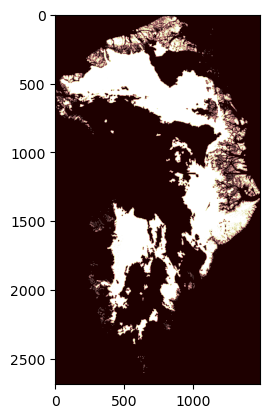

In [79]:
src = rasterio.open(optical_path)
plt.imshow(src.read(1), cmap='pink')
#<matplotlib.image.AxesImage object at 0x...>
plt.show()

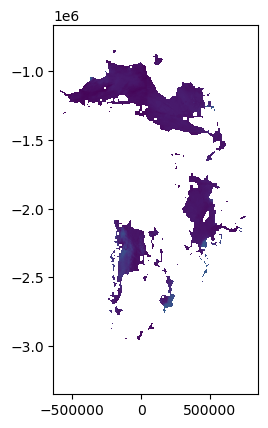

<AxesSubplot: >

In [58]:
rasterio.plot.show(src)

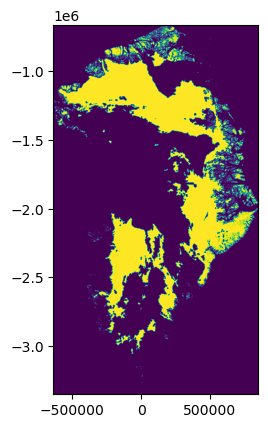

<AxesSubplot: >

In [60]:
rasterio.plot.show(src.read(), transform=src.transform)

## Overlay

1. overlay
2. analyse and look at thresholds -> compare, do boundaries based on melting (0.64) threshold
3. boudaries for plot? # https://rasterio.readthedocs.io/en/latest/topics/plotting.html